# Simulations on Real Data from Fairhaven/New Bedford Deployment

In [4]:
# Imports
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain
import ipp_library

# necessary imports
import pandas as pd
from matplotlib.image import NonUniformImage
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import seaborn as sns
from descartes import PolygonPatch
from shapely.geometry import LineString
from scipy.optimize import curve_fit
# import sensor_plotting as sp

%matplotlib inline
%pylab inline

pd.set_option('display.max_columns',None)
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

Populating the interactive namespace from numpy and matplotlib


In [5]:
# all_data = './jetyak_new_bedford/cleandata/all_interpolated.csv'
# fh_data = './jetyak_new_bedford/cleandata/fh_interpolated.csv'
# nb_data = './jetyak_new_bedford/cleandata/nb_interpolated.csv'

# ctd_geo = './jetyak_new_bedford/cleandata/ctd_geo.csv'
# gga_geo = './jetyak_new_bedford/cleandata/gga_geo.csv'
# nit_geo = './jetyak_new_bedford/cleandata/nit_geo.csv'
# op_geo = './jetyak_new_bedford/cleandata/op_geo.csv'
# air_geo = './jetyak_new_bedford/cleandata/air_geo.csv'


all_data = '../nb-effluent-plumes/data/clean/all_interpolated.csv'
fh_data = '../nb-effluent-plumes/data/clean/fh_interpolated.csv'
nb_data = '../nb-effluent-plumes/data/clean/nb_interpolated.csv'

ctd_geo = '../nb-effluent-plumes/data/clean/ctd_geo.csv'
gga_geo = '../nb-effluent-plumes/data/clean/gga_geo.csv'
nit_geo = '../nb-effluent-plumes/data/clean/nit_geo.csv'
op_geo = '../nb-effluent-plumes/data/clean/op_geo.csv'
air_geo = '../nb-effluent-plumes/data/clean/air_geo.csv'



In [6]:
all_df = pd.read_table(all_data, delimiter=',', header=[0,1])
fh_df = pd.read_table(fh_data, delimiter=',', header=[0,1])
nb_df = pd.read_table(nb_data, delimiter=',', header=[0,1])

ctd_df = pd.read_table(ctd_geo, delimiter=',', header=[0,1])
gga_df = pd.read_table(gga_geo, delimiter=',', header=[0,1])
nit_df = pd.read_table(nit_geo, delimiter=',', header=[0,1])
air_df = pd.read_table(air_geo, delimiter=',', header=[0,1])
op_df = pd.read_table(op_geo, delimiter=',', header=[0,1])

 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0,18,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


(1458, 2) (1458, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s06  0006   6.392139e+03   1.976157e+05 
    02s09  0012   4.794751e+03   6.698245e+01 
    05s23  0030   4.773409e+03   9.878163e-01 
    06s63  0038   4.772501e+03   4.100327e-09 
Runtime:     06s63
Optimization status: Converged

Optimization restart 1/2, f = 4772.50086267
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s37  0007   9.525878e+02   9.942124e+03 
    03s57  0018   8.448319e+02   3.455292e+02 
    04s96  0025   8.445479e+02   1.606474e-08 
Runtime:     04s96
Optimization status: Converged

Optimization restart 2/2, f = 844.547911882
  rbf.         |               value  |  constraints  |  priors
  variance     |  12.932631691153484  |      +ve      |        
  lengthscale  |   4.100335551775644  |      +ve      |        


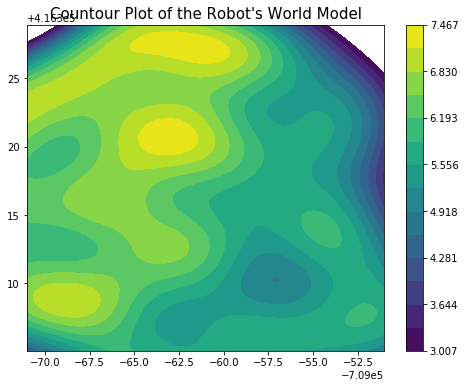

In [7]:
fh_d = fh_df.loc[fh_df['p'].drop_duplicates(subset=['Longitude']).dropna().index]
fh_d = fh_d.loc[fh_d['gga'].dropna(subset=['CO2_ppm_adjusted']).index]
fh_d = fh_d[fh_d['p']['Latitude'] < 41.634]
fh_d = fh_d[fh_d['p']['Latitude'] > 41.6305]
fh_d = fh_d[fh_d['p']['Longitude'] > -70.9071]
fh_d = fh_d[fh_d['ctd']['Depth'] > 0.2]
fh_d = fh_d[fh_d['ctd']['Depth'] < 0.5]
fh_d = fh_d[fh_d['gga']['CH4_ppm_adjusted'] < 8.5]


# ctd_fh = ctd_df.drop(ctd_df[ctd_df.Julian_Date > (0.205+2458207)].index)
# ctd_nb = ctd_df.drop(ctd_df[ctd_df.Julian_Date < (0.231+2458207)].index)
# fh_d = fh_d.dropna()

xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

# plt.scatter(xv*100, yv*100)

ranges = [min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000]

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape

kern = GPy.kern.RBF(input_dim = 2, lengthscale=0.001, variance=np.var(z))
mod = GPy.models.GPRegression(xvals, zvals, kern)
mod.initialize_parameter()
mod.optimize_restarts(num_restarts = 2, messages = True)
print kern

xc = np.linspace(ranges[0], ranges[1], 100)
yc = np.linspace(ranges[2], ranges[3], 100)
xc, yc = np.meshgrid(xc, yc, sparse = False, indexing= 'xy')
data = np.vstack([xc.ravel(), yc.ravel()]).T
obs, var = mod.predict(data, full_cov=False, include_likelihood=True)

fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.set_xlim(ranges[0:2])
ax2.set_ylim(ranges[2:])       
ax2.set_title('Countour Plot of the Robot\'s World Model')     
plot = ax2.contourf(xc, yc, obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
# ax2.scatter(xc, yc, c=obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
ax2.scatter(xv, yv, c=z, cmap='viridis', vmin=min(z), vmax=max(z))
ax2.plot(-70.90668, 41.63118, 'r*', markersize=10)
cbar = fig2.colorbar(plot)

In [ ]:
reload(ipp_library)
from ipp_library import *

# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, and mes'''
xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

LENGTH = 4.10
VAR = 12.93

# plt.scatter(xv*100, yv*100)

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape
print max(xv)*10000 - min(xv)*10000, max(yv)*10000 - min(yv)*10000
print np.mean(zvals), np.var(zvals)

ranges = (min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000)

reward_function = 'mean'
gp_world = GPModel(ranges, LENGTH, VAR)
gp_world.add_data(xvals, zvals)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = VAR, 
                    lengthscale = LENGTH, 
                    visualize = True,
                    seed = None,
                    model = gp_world)

evaluation = Evaluation(world = world, reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
x1observe = np.linspace(-709070.99900000007, -709051.0340000001, 20)
x2observe = np.linspace(416305.07100000005, 416328.92400000006, 20)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

print ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0)

# Create the point robot
#obot.__class__ = Nonmyopic_Robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
              #prior_dataset =  (data, observations), 
              init_lengthscale = LENGTH, 
              init_variance = VAR, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 3.0, 
              turning_radius = 0.05,
              sample_step = 1.0,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True,
              computation_budget = 10.0,
              rollout_length = 5) 

robot.planner(T = 175)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()


(1458, 2) (1458, 1)
19.965 23.853
6.370657765702211 0.3330176189875886
World max value 7.467374396955659 at location [-709064.919  416322.422]
(-709061.0165000001, 416316.99750000006, 0)
[ 0 ] Current Location:   (-709061.0165000001, 416316.99750000006, 0)
Number of rollouts: 4597 	 Size of tree: 13895
Current predicted max and value: 	[[0. 0.]] 	0.0
[ 1 ] Current Location:   (-709062.5378478726, 416319.5831335106, 2.1026315789473684)
Number of rollouts: 4008 	 Size of tree: 11971
Current predicted max and value: 	[-709062.04917241  416319.0537931 ] 	6.916639463861872
[ 2 ] Current Location:   (-709059.8975668096, 416321.00753370294, 0.49473684210526314)
few paths available!
Number of rollouts: 3990 	 Size of tree: 11381
Current predicted max and value: 	[-709061.36072414  416319.87631034] 	7.15983044923771
[ 3 ] Current Location:   (-709057.4531822124, 416322.7467817996, 0.618421052631579)
few paths available!
few paths available!
few paths available!
few paths available!
few paths av

Number of rollouts: 909 	 Size of tree: 3113
Current predicted max and value: 	[-709062.04917241  416325.63393103] 	7.355725844725372
[ 29 ] Current Location:   (-709055.1809755388, 416316.90247053857, -8.286842105263153)
Number of rollouts: 917 	 Size of tree: 3126
Current predicted max and value: 	[-709062.04917241  416325.63393103] 	7.350960690117953
[ 30 ] Current Location:   (-709056.7657420292, 416314.3552141378, -8.410526315789468)
Number of rollouts: 929 	 Size of tree: 3158
Current predicted max and value: 	[-709062.04917241  416325.63393103] 	7.368763873182907
[ 31 ] Current Location:   (-709058.6526549931, 416312.0229278204, -8.534210526315784)
Number of rollouts: 884 	 Size of tree: 3071
Current predicted max and value: 	[-709062.04917241  416325.63393103] 	7.380137701802342
[ 32 ] Current Location:   (-709061.6517341192, 416311.948601544, -9.399999999999995)
Number of rollouts: 932 	 Size of tree: 3273
Current predicted max and value: 	[-709062.73762069  416323.98889655] 	

few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
Number of rollouts: 910 	 Size of tree: 2862
Current predicted max and value: 	[-709061.36072414  416327.27896552] 	7.153237863027016
[ 65 ] Current Location:   (-709069.0130249183, 416326.20394821063, -10.018421052631565)
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!


Number of rollouts: 846 	 Size of tree: 3089
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.213467904771159
[ 90 ] Current Location:   (-709066.5513909004, 416318.10895896173, 2.9684210526315935)
Number of rollouts: 831 	 Size of tree: 2890
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.213552383259261
[ 91 ] Current Location:   (-709064.6072737536, 416320.3937802938, 0.8657894736842251)
Number of rollouts: 819 	 Size of tree: 2841
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.214470336820668
[ 92 ] Current Location:   (-709061.6072737536, 416320.3937802938, 1.4654943925052066e-14)
Number of rollouts: 824 	 Size of tree: 2924
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.220531693150876
[ 93 ] Current Location:   (-709063.1286216261, 416317.80814678327, -2.1026315789473538)
Number of rollouts: 835 	 Size of tree: 2986
Current predicted max and value: 	[-709062.73762069  416320.6988

Number of rollouts: 756 	 Size of tree: 2889
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.24026679752864
[ 127 ] Current Location:   (-709063.8419089519, 416316.10970621463, -19.913157894736823)
Number of rollouts: 758 	 Size of tree: 2634
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.240252893577303
[ 128 ] Current Location:   (-709062.3207382793, 416318.69544397877, -17.810526315789456)
Number of rollouts: 756 	 Size of tree: 2830
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.240304789781797
[ 129 ] Current Location:   (-709065.2294689998, 416319.42980464996, -15.95526315789472)
Number of rollouts: 764 	 Size of tree: 2720
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.240245369964431
[ 130 ] Current Location:   (-709062.6629878368, 416320.98324420134, -18.30526315789472)
Number of rollouts: 765 	 Size of tree: 2796
Current predicted max and value: 	[-709062.73762069  416320.69

Number of rollouts: 712 	 Size of tree: 2624
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.250919475329865
[ 164 ] Current Location:   (-709061.5646322495, 416321.39606493275, -18.305263157894714)
Number of rollouts: 683 	 Size of tree: 2532
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.2509493110987036
[ 165 ] Current Location:   (-709061.5272606817, 416318.39629771415, -20.40789473684208)
Number of rollouts: 670 	 Size of tree: 2402
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.251167627640337
[ 166 ] Current Location:   (-709064.526349967, 416318.4702129294, -22.015789473684187)
Number of rollouts: 717 	 Size of tree: 2556
Current predicted max and value: 	[-709062.73762069  416320.69882759] 	7.251145895209163
[ 167 ] Current Location:   (-709062.9417580466, 416321.01757792995, -24.118421052631554)
Number of rollouts: 711 	 Size of tree: 2651
Current predicted max and value: 	[-709062.73762069  416320.6